## Toxic: TF-IDF/NMF

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.pipeline import Pipeline

from wordcloud import WordCloud
from sklearn.manifold import TSNE

from time import time

In [5]:
df = pd.read_pickle('../data/toxictrain.pkl')
print(df.shape)
# df.head()

(159571, 24)


### Assumptions

In [6]:
df_t = df[df['rating']>0]

n_samples = 2000
n_features = 1000

class_list = ['clean','toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
model_list = ['LDA','NMF-FN','NMF-KL']

In [4]:
# See implementation at http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
def print_top_words(model, feature_names, n_top_words):
    listy = []
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        listy.append(message)
    return listy   

def tfidf_nmf_dict(dataset,class_list,n_components,n_top_words):
    class_tfidfnmf = {}    
    for item in class_list:
        data = dataset[dataset[item]==1]

        tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=1,max_features=n_features,stop_words='english')
        tfidf = tfidf_vectorizer.fit_transform(data.comment_text_s)
        
        tf_vectorizer = CountVectorizer(max_df=0.95, min_df=1,max_features=n_features,stop_words='english')
        tf = tf_vectorizer.fit_transform(data.comment_text_s)
        
        nmf = NMF(n_components=n_components, random_state=1,alpha=.1, l1_ratio=.5).fit(tfidf)
        
        tfidf_feature_names = tfidf_vectorizer.get_feature_names()

        aa = print_top_words(nmf, tfidf_feature_names, n_top_words)
        
        nmf = NMF(n_components=n_components, random_state=1,beta_loss='kullback-leibler', solver='mu', 
                  max_iter=1000, alpha=.1,l1_ratio=.5).fit(tfidf)
        
        tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    
        bb = print_top_words(nmf, tfidf_feature_names, n_top_words)
        
        lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,learning_method='online',
                                        learning_offset=50.,random_state=0)
        lda.fit(tf)
        
        tf_feature_names = tf_vectorizer.get_feature_names()
        
        cc = print_top_words(lda, tf_feature_names, n_top_words)
        class_tfidfnmf[item] = {'NMF-FN':aa, 'NMF-KL':bb, 'LDA':cc}
    
    return class_tfidfnmf

In [5]:
tnd = tfidf_nmf_dict(df,class_list,1,20)

In [6]:
tnd

{'clean': {'LDA': ['Topic #0: article page wikipedia talk just like don think edit know articles people use thanks time did user ve good deletion'],
  'NMF-FN': ['Topic #0: talk article page wikipedia just like don edit thanks think know user did articles editing pages people use time help'],
  'NMF-KL': ['Topic #0: talk wikipedia page article just like think thanks don know time edit ve did people use user thank want good']},
 'identity_hate': {'LDA': ['Topic #0: nigger gay fuck fucking jew fat like faggot shit hate bitch ass die just stupid wikipedia people suck don page'],
  'NMF-FN': ['Topic #0: gay fuck faggot fucking nigger shit ass bitch like fag life page cunt hey wikipedia little ur just stop stupid'],
  'NMF-KL': ['Topic #0: gay fuck fucking faggot nigger like shit people ass wikipedia just stupid bitch stop think know suck page jew don']},
 'insult': {'LDA': ['Topic #0: fuck fucking like wikipedia don just shit suck page know ass bitch stupid moron people hi nigger idiot sto

In [7]:
tnd = pd.DataFrame(tnd,dtype=str)
tnd

,clean,identity_hate,insult,obscene,severe_toxic,threat,toxic
LDA,[Topic #0: article page wikipedia talk just li...,[Topic #0: nigger gay fuck fucking jew fat lik...,[Topic #0: fuck fucking like wikipedia don jus...,[Topic #0: fuck fucking shit wikipedia like do...,[Topic #0: fuck shit suck fucking ass bitch su...,[Topic #0: die kill ass going fuck fucking wik...,[Topic #0: fuck wikipedia like just don page p...
NMF-FN,[Topic #0: talk article page wikipedia just li...,[Topic #0: gay fuck faggot fucking nigger shit...,[Topic #0: fuck fucking bitch shit asshole ass...,[Topic #0: fuck fucking shit bitch wikipedia a...,[Topic #0: fuck bitch fucking asshole shit ass...,[Topic #0: die kill fucking fuck hope shit goi...,[Topic #0: fuck fucking shit wikipedia don bit...
NMF-KL,[Topic #0: talk wikipedia page article just li...,[Topic #0: gay fuck fucking faggot nigger like...,[Topic #0: fuck fucking wikipedia shit like st...,[Topic #0: fuck fucking shit wikipedia like su...,[Topic #0: fuck fucking shit suck bitch wikipe...,[Topic #0: kill die going fucking fuck hope sh...,[Topic #0: fuck wikipedia like fucking just sh...


In [8]:
tnd.identity_hate

LDA       [Topic #0: nigger gay fuck fucking jew fat lik...
NMF-FN    [Topic #0: gay fuck faggot fucking nigger shit...
NMF-KL    [Topic #0: gay fuck fucking faggot nigger like...
Name: identity_hate, dtype: object

In [9]:
# tnd['LDA'] = tnd['LDA'].apply(lambda x: x[0].split())
# tnd.head()

In [10]:
# tnd1 = tnd.loc['LDA','clean'][0].split()[2:]

In [40]:
def create_wordcloud(text,width,height,max_words,title):
    wordcloud = WordCloud(width=width,height=height,max_words=max_words).generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title,fontweight='bold',fontsize=16)

    
def prep_dict(dictionary, model_list):
    fig = plt.figure(figsize=(20,30))
    model_words = {}
    i = 0
    for item in class_list:
        for mod in model_list:
            ax = fig.add_subplot(7,3,i+1)
            data = dictionary.loc[mod,item][0].split()[2:]
            text = ' '.join(data)
            title = str(mod + " Topic: " + item)
            filepath = '../charts/TFIDFNMF_wc_' + mod + "_" + item + '.png'
            create_wordcloud(text,400,200,200,title)
            model_words[(item,mod)] = data
            i += 1   
    plt.tight_layout()
    plt.savefig(filepath)
    print('file saved at ' + filepath)
    return model_words

file saved at ../charts/TFIDFNMF_wc_NMF-KL_identity_hate.png


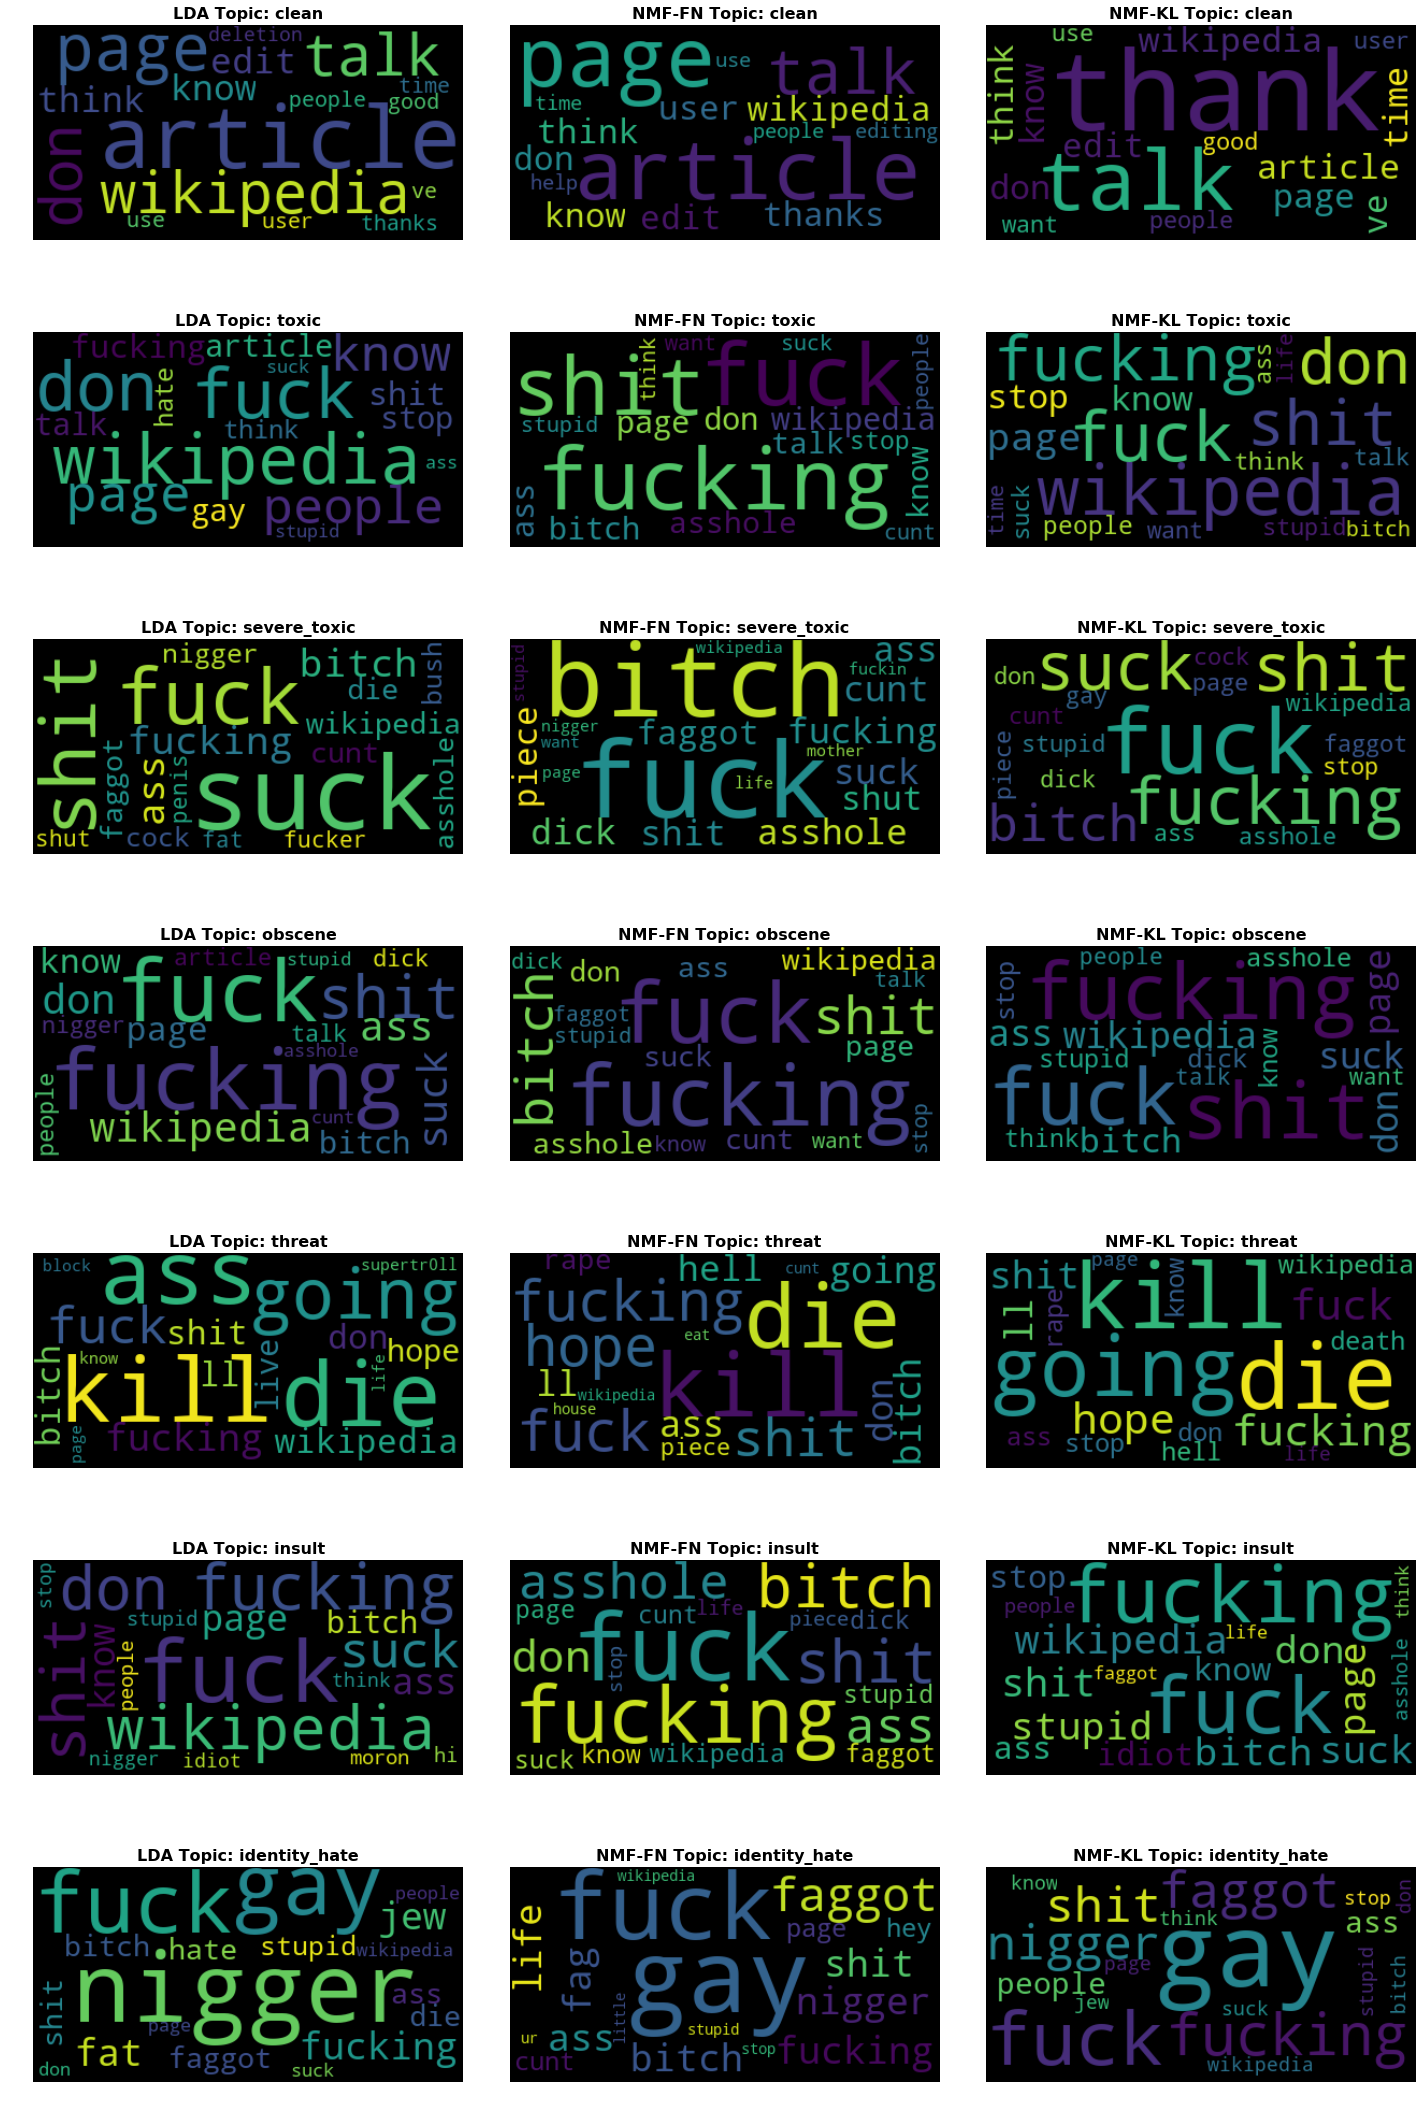

In [41]:
mw = prep_dict(tnd,model_list)
mw = pd.DataFrame(mw)

### Dimensionality Reduction

In [9]:
# Code inspired by https://github.com/ailchau/Metis_Projects/blob/master/wrangling_with_restaurant_reviews/wrangling_with_restaurant_reviews.ipynb
tfidf = TfidfVectorizer(min_df=0.0001)
X_positive = tfidf.fit_transform(df_t.comment_text_s)
positive_word_list = tfidf.get_feature_names()
len(positive_word_list)

14735

In [10]:
nmf = NMF(n_components=6, random_state=42, alpha=.1, l1_ratio=.5, init='nndsvd')
X_positive_reduced = nmf.fit_transform(X_positive)
components = nmf.components_
print(components)

[[0.0041271  0.02543197 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [11]:
X_positive_reduced.shape

(16225, 6)

In [12]:
# examine the top 20 words associated with each latent topic
for index,values in enumerate(components):
    print("topic {}".format(index))
    temp = list(zip(positive_word_list, components[index]))
    print(sorted(temp, key=lambda x: x[1], reverse=True)[:20],"\n")

topic 0
[('the', 3.849360925670397), ('to', 2.5570673697523554), ('is', 2.330228701351455), ('and', 2.2100435889608927), ('of', 2.0459018902701054), ('it', 1.9535724736214648), ('that', 1.9166055177828232), ('this', 1.4602605638683515), ('in', 1.3924575485103416), ('not', 1.2193891804316586), ('on', 1.0813586169042855), ('for', 1.021226319800541), ('be', 0.965263026085534), ('have', 0.928023797516827), ('he', 0.9151674481257991), ('as', 0.902697241518399), ('was', 0.8814131360829166), ('my', 0.7913229056619604), ('with', 0.7910536759420619), ('what', 0.7718250105644214)] 

topic 1
[('you', 7.889679877673267), ('are', 2.708127119900978), ('me', 1.379467508190373), ('re', 1.2246449039068028), ('do', 1.0978547230388989), ('don', 0.8684282988592475), ('to', 0.8370198853744809), ('why', 0.8251990112209479), ('know', 0.6516359200710713), ('like', 0.596632898623879), ('what', 0.5847889724130682), ('have', 0.5822128641208054), ('if', 0.5526094918187285), ('will', 0.5441461404469023), ('and', 0

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# try out a range of cluster sizes to find the one with the best inertia and silhouette scores
ns = np.arange(2, 20, 1)
inertias = []
Sil_coefs = []
for n in ns:
    kmeans = KMeans(n_clusters=n, init="k-means++", random_state=81617).fit(X_positive_reduced)
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    Sil_coefs.append(silhouette_score(X_positive_reduced, labels, metric='euclidean'))

In [13]:
X_positive_reduced.shape

(16225, 6)

In [17]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=500, random_state=42)
tsne_positive = tsne.fit_transform(X_positive_reduced)

In [18]:
df_tsne_positive = pd.DataFrame(tsne_positive, columns=["tsne_x", "tsne_y"])
df_tsne_positive.shape

(16225, 2)

In [34]:
df_tsne_positive["Cluster"] = labels
df_tsne_positive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16225 entries, 0 to 16224
Data columns (total 3 columns):
tsne_x     16225 non-null float32
tsne_y     16225 non-null float32
Cluster    16225 non-null int32
dtypes: float32(2), int32(1)
memory usage: 190.2 KB


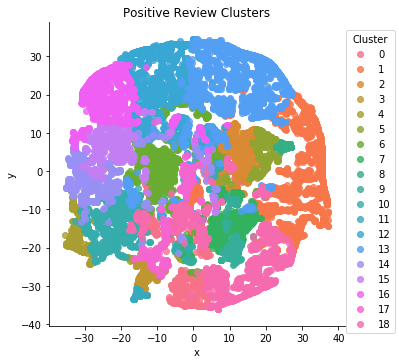

In [35]:
tsne_positive = sns.lmplot("tsne_x", "tsne_y", data=df_tsne_positive, fit_reg=False, hue="Cluster")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Positive Review Clusters");